# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Этапы проекта:

Проведение исследовательского анализа набора фотографий.  
Подготовка данных к обучению.  
Обучение нейронной сети и рассчёт её качества.

In [1]:
#исследовательский анализ данных
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

```python
# обучение модели
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
```

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


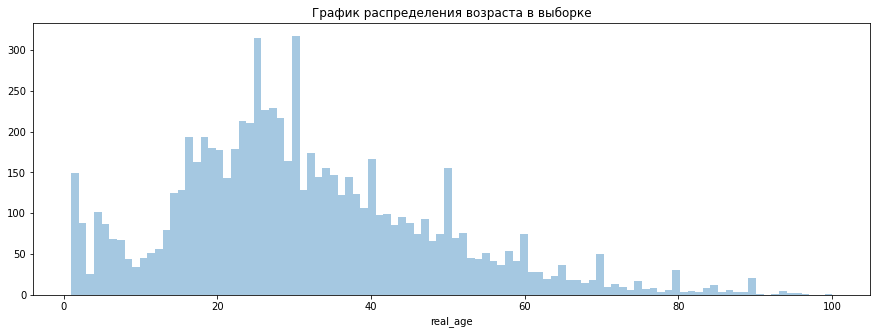

In [22]:
plt.figure(figsize=(15,5));
sns.distplot(labels.real_age, kde=False, bins=100);
plt.title('График распределения возраста в выборке')
plt.show();

Стоит обратить внимание на пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его. Поэтому, некоторые "круглые" года в датасете некорректные.

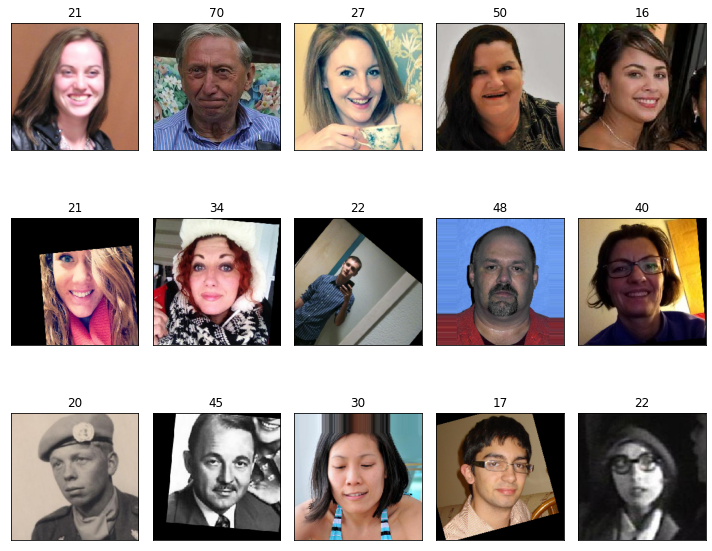

In [26]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете находится 7591 фотография. 

Наибольшая часть датасета состоит из фотографий людей в возрасте от 20 до 40 лет. Максимальный возраст 100, минимальный 1.

На некоторыx фотографиях присутствует не один человек, в кадр попадает часть лица другого человека. Некоторые люди ихображены в головных уборах, очках. Присутствуют фотографии с людьми в полный рост. Фотографии разного качества. Думаю, что это осложнит обучение модели.

Общая ориентация фотографий примерно одинакова - в некоторых фото их уже повернули за нас, чтобы выровнять положение лица, значит нам их не обязательно поворачивать, а начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). В итоге, размер изображений мы приведем к единому перед обучением модели.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 65s - loss: 244.8903 - mae: 10.9872 - val_loss: 783.7024 - val_mae: 22.9250
Epoch 2/5
190/190 - 41s - loss: 63.9054 - mae: 5.9930 - val_loss: 532.6114 - val_mae: 17.6445
Epoch 3/5
190/190 - 48s - loss: 34.2917 - mae: 4.5237 - val_loss: 188.4940 - val_mae: 10.1273
Epoch 4/5
190/190 - 52s - loss: 21.4278 - mae: 3.5729 - val_loss: 97.0026 - val_mae: 7.6727
Epoch 5/5
190/190 - 50s - loss: 15.5804 - mae: 3.0863 - val_loss: 79.5139 - val_mae: 6.7231

48/48 - 8s - loss: 79.5139 - mae: 6.7231
Test MAE: 6.7231


```

## Анализ обученной модели

Построена и обучена свёрточная нейронная сеть на датасете с фотографиями людей.

Модель сверточной нейронной сети построена на ResNet50.

За 4 эпохи удалось уменьшить MAE на тестовой выборке с 22.9 до 7.6. Что соотвествует условию решения задачи.

За 5 эпох удалось уменьшить MAE на тестовой выборке с 22.9 до 6.7. Возможно, что дальнейшее обучение улучшит результат.

## Вывод

В ходе проекта была построена модель сверточной нейронной сети на ResNet50 для определения возраста клиентов с помощью фотофиксации в прикассовой зоне. Получено значение MAE = 6.7